In [ ]:
import sys

sys.path.insert(0, '../')
from scipy import stats
import matplotlib.pyplot as plt, numpy as np
from PlexSim.plexsim.models import *
import scipy, networkx as nx, multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
from Utils import IO
from Toolbox import infcy
# %matplotlib 
dataDir = '../Graphs' # relative path careful
df    = IO.readCSV('{}/Graph_min1_1.csv'.format(dataDir), header = 0, index_col = 0)
h     = IO.readCSV('{}/External_min1_1.csv'.format(dataDir), header = 0, index_col = 0)
# df[abs(df) > 0] = 1
graph   = nx.from_pandas_adjacency(df) 

# print(df)
# attr = {node : \
#         dict(H = row['externalField']) for node, row in h.iterrows()}
# nx.set_node_attributes(graph, attr)
# graph.__version__ = .5


# assert 0
# graph = nx.random_graphs.erdos_renyi_graph(10, .25)
# graph  = nx.path_graph(5, nx.DiGraph())
# graph.add_edge(0, 0)
# graph  = nx.path_graph(5, nx.DiGraph())
n = 64
# graph  = nx.path_graph(n, nx.DiGraph())
# graph.add_edge(0, 0, weight = 1);
# graph.add_edge(0, n + 1)
# graph = nx.random_regular_graph(4,10)

graph = nx.grid_2d_graph(n,n, periodic = 1)
# graph = nx.DiGraph()
# graph.add_node(0)
# graph.add_edge(0, 1)
# graph = nx.erdos_renyi_graph(10, .5)
# graph = nx.path_graph(3)
# graph = nx.grid_2d_graph(64,64, periodic = True)
# graph = nx.random_regular_graph(3, 10)
agentStates = np.arange(0, 2).tolist()
model = Ising(graph, \
              updateType= 'sync',\
             )
# temps = np.geomspace(.01, 5, 20)
temps = np.linspace(0, 5, 15)
mag, sus = model.matchMagnetization(temps, n = 1000)
# print(mag)
# mag  = (mag - mag.min())  / (mag.max() - mag.min())
func = lambda x, a, b, c, d :  a / (1 + np.exp(b * (x - c))) + d # tanh(-a * x)* b + c
a, b = scipy.optimize.curve_fit(func, temps, mag, maxfev = 10000)
xx = np.linspace(0, max(temps))

match = .8* max(mag)
print(match, max(mag))
# match = .9
fr  = lambda x : abs(func(x, *a) - match)
# rr  = scipy.optimize.root(fr, 0, \
#            9               options = dict(bounds = (0, np.inf)))
rr = scipy.optimize.fmin(fr, 0)
print(rr)
fig, ax = plt.subplots();
ax.scatter(temps,  mag)
ax.plot(xx, func(xx, *a), 'k--')
ax.scatter(rr, func(rr, *a), c = 'red')
model.t = 1
plt.setp(ax, **dict(xlabel = 'Temperature', ylabel = '<abs(M)>'))
fig.show()

fig, ax = plt.subplots()
ax.plot(model.simulate(100).mean(1))
fig.show()
print(model.adj)

ValueError: too many values to unpack (expected 2)

<ipython-input-5-d4761de47248>:47: RuntimeWarning: divide by zero encountered in log2
  px, mi = infcy.mutualInformation(pconditional, pstates)
<ipython-input-5-d4761de47248>:47: RuntimeWarning: invalid value encountered in multiply
  px, mi = infcy.mutualInformation(pconditional, pstates)
<ipython-input-5-d4761de47248>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig, ax=  plt.subplots(); ax.plot(res.mean(1)) ; fig.show()
<ipython-input-5-d4761de47248>:83: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[('0', 1), ('1', 1)]


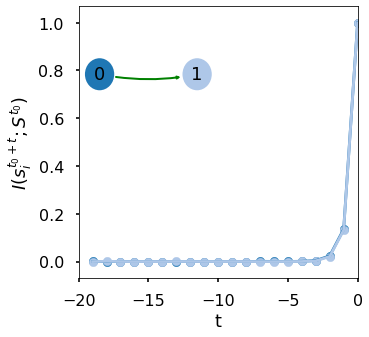

In [5]:
# model.nudges = {"2" : 1}
model.nudges = {}
model.reset()

# model.t = rr
# print(model.t, rr)
res = model.simulate(10000)
nWindow = 20
binned = np.array([np.roll(res, i, axis = 0)[:nWindow] for i in range(len(res))])

# create probability distribution of states
from collections import Counter


pstates = Counter((tuple(i) for i in binned[:, -1]))
z       = sum(list(pstates.values()))
pstates = {i : j / z for i, j in pstates.items()}

pconditional = {}
# collect conditional trials
for b in binned:
    target = tuple(b[-1])
    tobebinned = b
    
    pconditional[target] = pconditional.get(target, ()) + (tobebinned,)

mapper = {i : idx for idx, i in enumerate(model.agentStates)}
from itertools import product

mi = np.zeros((model.nNodes, nWindow), dtype = float)
for state in pstates:
    tobebinned = np.array([i for i in pconditional.get(state)])

    nTrials, deltas, nnodes = tobebinned.shape
    
    cNode = np.zeros((deltas, nnodes, len(agentStates)), dtype = float)
    for (delta, node) in product(*map(range, (deltas, nnodes))):
        tmp = tobebinned[:, delta, node]
        tmp = Counter(tmp)
        z   = sum(list(tmp.values()))
        tmp = {i : j / z for i, j in tmp.items()}
        for nodestate, val in tmp.items():
            idx = mapper[nodestate]
            cNode[delta, node, idx] += val # * 1 / nTrials
#     print(cNode); assert 0
    pconditional[state]  = cNode
px, mi = infcy.mutualInformation(pconditional, pstates)
fig, ax=  plt.subplots(); ax.plot(res.mean(1)) ; fig.show()

from matplotlib import style
style.use('seaborn-poster')
%matplotlib inline
fig, right = plt.subplots(figsize = (5,5))
# left.plot(res)
# middle.plot(binned.mean(1))
xr = np.arange(nWindow)[::-1] * - 1
colors = plt.cm.tab20(range(model.nNodes))
mi = (mi - mi.min()) / (mi.max() - mi.min())
for i in range(model.nNodes):
    right.plot(xr,  mi[:, i], color = colors[i],\
              linestyle = 'solid', markersize = 100) 
    right.scatter(xr, mi[:, i], color = colors[i],\
                 s = 70)
    right.set_xlim(-20, 0)
# right.set_yscale('log')
inax = right.inset_axes([0, .5, .5, .5])
from Utils.plotting import addGraphPretty
theta = np.pi * 2 / model.nNodes
positions = {node : (np.cos(theta * idx), np.sin(theta * idx)) for node, idx in model.mapping.items()}
addGraphPretty(model.graph, ax = inax, positions = positions,\
               colors = colors,\
               circle = dict(radius = .3),\
              annotate = dict(fontsize = 60))
inax.axis('off')
inax.invert_xaxis()
right.set_ylabel('$I(s_i^{t_0 + t}; S^{t_0})$')
right.set_xlabel('t')
# right.set_yticks((0, 1))
# fig.savefig('example_reverse.svg',\
#            bbox_inches = 'tight',\
#            pad_inches = 0, transparent = 1)
print(nx.degree(model.graph))
fig.show() 

In [10]:
mi

array([[2.77141006e-04, 9.15422543e-05],
       [3.97107392e-04, 1.47294448e-04],
       [1.47553093e-04, 8.73753426e-06],
       [1.38928305e-05, 1.21393380e-04],
       [4.72922030e-04, 4.17241282e-05],
       [6.12267832e-05, 4.31223959e-05],
       [4.46481888e-05, 5.20482848e-05],
       [4.40859131e-05, 1.00696674e-04],
       [5.74304992e-05, 2.88443033e-05],
       [1.58819309e-04, 2.52632984e-04],
       [6.22545500e-05, 2.25209808e-04],
       [0.00000000e+00, 1.77489044e-04],
       [1.19475058e-04, 6.68934826e-05],
       [2.44024691e-04, 7.20689371e-05],
       [5.00898742e-04, 7.46444621e-05],
       [8.74782407e-04, 5.31690077e-04],
       [3.95025310e-03, 3.21161917e-03],
       [2.75645202e-02, 2.47646451e-02],
       [1.41548737e-01, 1.36019911e-01],
       [1.00000000e+00, 9.99985255e-01]])

In [66]:
model.reset()
print(model.rules)
model.simulate(10)

{2: [0, 0], 0: [0, 0], 1: [1, 1, 0, 1]}
None


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

NameError: name 'model' is not defined

In [ ]:
# print(model.rules)

In [ ]:
model.reset()

model.t = rr
# print(model.t, rr)
res = model.simulate(1000)
nWindow = 20
binned = np.array([np.roll(res, i, axis = 0)[:nWindow] for i in range(len(res))])

# create probability distribution of states
from collections import Counter


pstates = Counter((tuple(i) for i in binned[:, -1]))
z       = sum(list(pstates.values()))
pstates = {i : j / z for i, j in pstates.items()}

pconditional = {}
# collect conditional trials
for b in binned:
    target = tuple(b[-1])
    tobebinned = b
    
    pconditional[target] = pconditional.get(target, ()) + (tobebinned,)

print(model.agentStates)
mapper = {i : idx for idx, i in enumerate(model.agentStates)}
from itertools import product

mi = np.zeros((model.nNodes, nWindow), dtype = float)
for state in pstates:
    tobebinned = np.array([i for i in pconditional.get(state)])

    nTrials, deltas, nnodes = tobebinned.shape
    
    cNode = np.zeros((deltas, nnodes, len(agentStates)), dtype = float)
    for (delta, node) in product(*map(range, (deltas, nnodes))):
        tmp = tobebinned[:, delta, node]
        tmp = Counter(tmp)
        z   = sum(list(tmp.values()))
        tmp = {i : j / z for i, j in tmp.items()}
        for nodestate, val in tmp.items():
            idx = mapper[nodestate]
            cNode[delta, node, idx] += val # * 1 / nTrials
#     print(cNode); assert 0
    pconditional[state]  = cNode
px, mi = infcy.mutualInformation(pconditional, pstates)
fig, ax=  plt.subplots(); ax.plot(res.mean(1)) 
fig.show()

In [ ]:
from matplotlib import style
style.use('seaborn-poster')
%matplotlib inline
fig, right = plt.subplots(figsize = (5,5))
# left.plot(res)
# middle.plot(binned.mean(1))
xr = np.arange(nWindow)[::-1] * - 1
colors = plt.cm.tab20(range(model.nNodes))
mi = (mi - mi.min()) / (mi.max() - mi.min())
for i in range(model.nNodes):
    right.plot(xr,  mi[:, i], color = colors[i],\
              linestyle = 'solid', markersize = 100) 
    right.scatter(xr, mi[:, i], color = colors[i],\
                 s = 70)
    right.set_xlim(-20, 0)
    
inax = right.inset_axes([0, .5, .5, .5])
from Utils.plotting import addGraphPretty
theta = np.pi * 2 / model.nNodes
positions = {node : (np.cos(theta * idx), np.sin(theta * idx)) for node, idx in model.mapping.items()}
addGraphPretty(model.graph, ax = inax, positions = positions,\
               colors = colors,\
               circle = dict(radius = .3),\
              annotate = dict(fontsize = 60))
inax.axis('off')
inax.invert_xaxis()
right.set_ylabel('$I(s_i^{t_0 + t}; S^{t_0})$')
right.set_xlabel('t')
# right.set_yticks((0, 1))
# fig.savefig('example_reverse.svg',\
#            bbox_inches = 'tight',\
#            pad_inches = 0, transparent = 1)
print(nx.degree(model.graph))
fig.show() 

In [ ]:
# plot mi
fig, ax = subplots(); ax.plot(H);
# ax.set_yscale('log')
# ax.set_xscale('log')

yy = res.mean(1)
N  = 5
xx = convolve(yy, np.ones((N,))/N, mode='valid')
fig, ax = subplots(); ax.plot(xx) #
fig, ax = subplots()
for node in model.nodeIDs:
    deg = len(model.edgeData[node])
    ax.scatter(deg, H[-2, node], label = node)
ax.legend(bbox_to_anchor = (1, 1))
   
fig, ax = subplots()
ax.hist(list(dict(nx.degree(graph)).values()))
setp(ax, **dict(xlabel = 'degree', ylabel = 'freq'));
fig, ax = subplots(); ax.hist(cc.values())
show()

print(res.dtype)

In [ ]:
# showing hellinger distance over time
colors = cm.tab20(arange(model.nNodes))
hd = lambda x, y: linalg.norm( sqrt(x) - sqrt (y), axis = -1) / sqrt(2)
d = zeros(H.shape)
for key, value in cond.items():
    x = value[..., None] / cc[key]
    d += hd(x,  1 - x)
d /= len(cond)


fig, ax = subplots(); 
[ax.plot(i, color = c) for i, c in zip(d.T, colors)]
ax.set_title('hellinger distance over time')
ax.set_xlim(len(x) - 15, len(x))

In [ ]:
from scipy import optimize
func = lambda x, a, b, c, d, e, f : a + b*exp(-c*x) + d * exp(-e * (x-f))
f2   = lambda x, a, b : func(x, *a) - b
fig, ax = subplots(figsize = (10, 10))
s = 0
idt = zeros((model.nNodes))
theta = 1e-3
colors = cm.tab20(arange(model.nNodes))
for idx, y in enumerate(H.T):
    y = y[::-1]
    x = arange(len(y))
    xx = linspace(0, 20, 1000)
    try:
        a, b = optimize.curve_fit(func, x,  y, maxfev = 100000) # fit
        
        ax.plot(xx, func(xx, *a), '--', color = colors[idx], alpha = 1) # plot fit
        
        findThis = a[0] + theta
        r  = optimize.root(f2,  x0 = 0, args = (a, findThis))
        rot = r.x if findThis < max(y) else 0

        print(a[0], rot, func(rot, *a))
        idt[idx] = rot
        ax.scatter(rot, func(rot, *a), color = colors[idx], s = 150, marker = '^', label = idx) # plot root 1
        s += 1
    except Exception as e : print(e)
    ax.scatter(x, y, color = colors[idx], s = 40)
ax.legend()
print(s / model.nNodes * 100)
ax.set_xlim(0,40)
ax.set_xlim(0, 3)
# ax.set_ylim(0, 1)
# ax.set_xscale('log')
# ax.set_yscale('log')

show()

In [ ]:
imshow(log(H.T))


In [ ]:
fig, ax = subplots()
for node, deg in model.graph.degree():
    idx = model.mapping[node]
    ax.scatter(deg, idt[idx], c = colors[idx])
# ax.set_ylim(0, -5)
# axx.set_ylim(0, -5)
# ax.set_yscale('log')



In [ ]:
model.nudges
